In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_dir=r"/home/admin1/Desktop/new data with aug/data-split/train"
val_data_dir=r"/home/admin1/Desktop/new data with aug/data-split/val"
test_data_dir=r"/home/admin1/Desktop/new data with aug/data-split/test"


train_datagen=ImageDataGenerator(#rescale=1./255,
                                 horizontal_flip=True,
                                 )

val_datagen=ImageDataGenerator()#rescale=1./255)
test_datagen=ImageDataGenerator()#rescale=1./255)

img_width,img_height=224,224
batch_size=16
train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

val_generator=val_datagen.flow_from_directory(val_data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode='categorical')

test_generator=test_datagen.flow_from_directory(test_data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode='categorical')

train_class_names = set()
num_train_samples=0
for i in train_generator.filenames:
    train_class_names.add(i.split('/')[0])
    num_train_samples+=1
print(num_train_samples)
train_class_names

val_class_names = set()
num_val_samples=0
for i in val_generator.filenames:
    val_class_names.add(i.split('/')[0])
    num_val_samples+=1
print(num_val_samples)
print(val_class_names)

num_classes = len(val_class_names)
num_classes

2024-02-28 12:20:28.282028: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 12:20:28.307998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 12:20:28.308023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 12:20:28.308630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 12:20:28.313016: I tensorflow/core/platform/cpu_feature_guar

Found 3498 images belonging to 5 classes.
Found 997 images belonging to 5 classes.
Found 505 images belonging to 5 classes.
3498
997
{'AMD', 'dia_ret', 'normal', 'cataract', 'glaucoma'}


5

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D,Conv2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model = ResNet50(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model.layers[:10]:
    layer.trainable = False
x = base_model.output
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model1 = Model(inputs=base_model.inputs, outputs=predictions)

2024-02-28 12:20:39.758244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 12:20:39.781420: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
checkpoint = ModelCheckpoint("aug_ResNet50.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=7,
                          verbose=1,
                          restore_best_weights=True)

callbacks=[checkpoint,earlystop]

epochs=20

In [5]:
model1.compile(loss='categorical_crossentropy',
                   optimizer=RMSprop(learning_rate=0.0001),
                   metrics=['accuracy', tf.keras.metrics.AUC()])
history1 = model1.fit(train_generator,
                         steps_per_epoch=num_train_samples//batch_size,
                         epochs=epochs,
                         callbacks=callbacks,
                         validation_data=val_generator,
                         validation_steps=num_val_samples//batch_size)

Epoch 1/20
218/218 [==============================] - ETA: 0s - loss: 0.4815 - accuracy: 0.8383 - auc: 0.9707
Epoch 1: val_loss improved from inf to 0.45041, saving model to aug_ResNet50.h5


/home/admin1/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


218/218 [==============================] - 209s 935ms/step - loss: 0.4815 - accuracy: 0.8383 - auc: 0.9707 - val_loss: 0.4504 - val_accuracy: 0.9254 - val_auc: 0.9818
Epoch 2/20
218/218 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.9242 - auc: 0.9914
Epoch 2: val_loss did not improve from 0.45041
218/218 [==============================] - 199s 911ms/step - loss: 0.2299 - accuracy: 0.9242 - auc: 0.9914 - val_loss: 0.4775 - val_accuracy: 0.9294 - val_auc: 0.9793
Epoch 3/20
218/218 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9552 - auc: 0.9950
Epoch 3: val_loss improved from 0.45041 to 0.37058, saving model to aug_ResNet50.h5
218/218 [==============================] - 199s 913ms/step - loss: 0.1430 - accuracy: 0.9552 - auc: 0.9950 - val_loss: 0.3706 - val_accuracy: 0.9264 - val_auc: 0.9802
Epoch 4/20
218/218 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9661 - auc: 0.9952
Epoch 4: val_loss improved from 0.3705

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer

def predict_class(image_path, model, train_generator):
    # Load the image
    img = load_img(image_path, target_size=(224, 224))

    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Expand the dimensions of the numpy array
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class of the image
    class_prediction = model.predict(img_array)

    # Get the predicted class index
    class_index = np.argmax(class_prediction)

    # Get the class indices and names
    class_indices = train_generator.class_indices
    class_names = dict((v, k) for k, v in class_indices.items())

    # Get the predicted class name
    class_name = class_names[class_index]

    # Return the predicted class name
    return class_name

In [7]:
import tensorflow as tf

# Load the model from the .h5 file
loaded_model = tf.keras.models.load_model('aug_ResNet50.h5')


In [8]:
user_input = "/home/admin1/Desktop/BE project/final dataset/AMD/AMD_107.png"
path = user_input
class_index = predict_class(path, loaded_model, train_generator)
print(class_index)

1/1 [==============================] - 1s 598ms/step
AMD


In [9]:
user_input = "/home/admin1/Desktop/BE project/final dataset/cataract/cataract_102.jpg"
path = user_input
class_index = predict_class(path, loaded_model, train_generator)
print(class_index)

1/1 [==============================] - 0s 388ms/step
cataract


In [10]:
user_input = "/home/admin1/Desktop/BE project/final dataset/dia_ret/dia_ret_185.png"
path = user_input
class_index = predict_class(path, loaded_model, train_generator)
print(class_index)

1/1 [==============================] - 0s 52ms/step
dia_ret


In [11]:
user_input = "/home/admin1/Desktop/BE project/final dataset/glaucoma/glaucoma_284.png"
path = user_input
class_index = predict_class(path, loaded_model, train_generator)
print(class_index)

1/1 [==============================] - 0s 45ms/step
glaucoma


In [13]:
user_input = "/home/admin1/Desktop/BE project/final dataset/normal/normal_159.png"
path = user_input
class_index = predict_class(path, loaded_model, train_generator)
print(class_index)

1/1 [==============================] - 0s 50ms/step
normal


In [14]:
from sklearn.metrics import classification_report
import numpy as np
# Assuming you have test data in a separate directory
test_data_dir = "/home/admin1/Desktop/new data with aug/data-split/test"
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

# Predict on the test set
y_pred = model1.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to class labels
y_pred_classes = [np.argmax(pred) for pred in y_pred]
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

Found 505 images belonging to 5 classes.
32/32 [==============================] - 23s 596ms/step
Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       102
    cataract       1.00      0.96      0.98       102
     dia_ret       0.96      0.99      0.97       110
    glaucoma       0.99      0.99      0.99       102
      normal       0.99      0.99      0.99        89

    accuracy                           0.99       505
   macro avg       0.99      0.99      0.99       505
weighted avg       0.99      0.99      0.99       505



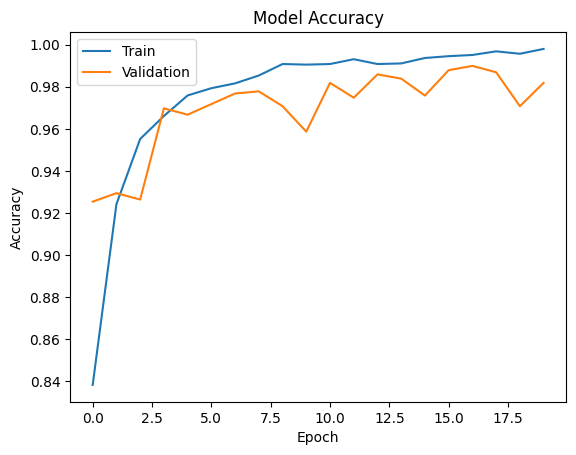

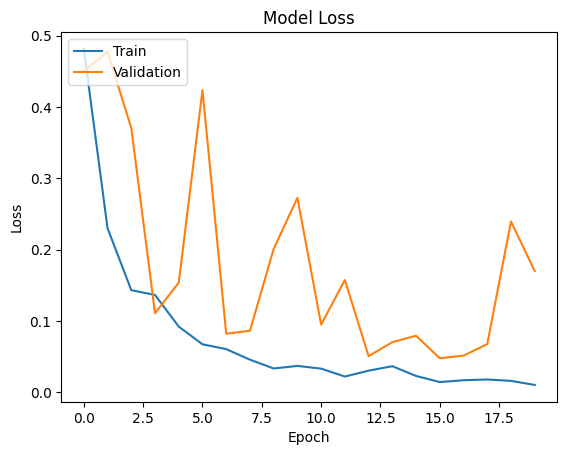

In [15]:
history = history1
import os
from matplotlib import pyplot as plt
# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Saving the accuracy plot
if not os.path.exists('graphs'):
    os.makedirs('graphs')
plt.savefig('graphs/resnet accuracy.png')

# Plotting the loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Saving the loss plot
if not os.path.exists('graphs'):
    os.makedirs('graphs')
plt.savefig('graphs/resnet loss.png')